# Parkinson's data exploration

## Imports

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import soundfile
import torchcodec
import IPython.display as ipd
import librosa
import librosa.display
import os
from pathlib import Path
from glob import glob
from scipy.io import wavfile
import parselmouth

from datasets import load_dataset, Audio

## Dataset exploration

#### Loading the dataset from huggingface

Dataset used: Giovanni Dimauro, Francesco Girardi, "Italian Parkinson's Voice and Speech", IEEE Dataport, June 11, 2019, doi:10.21227/aw6b-tg17

In [2]:
#Loading huggingface birgermoell/Italian_Parkinsons_Voice_and_Speech dataset
ds = load_dataset("birgermoell/Italian_Parkinsons_Voice_and_Speech")
ds

DatasetDict({
    train: Dataset({
        features: ['audio'],
        num_rows: 1662
    })
})

Possible requirements for the dataset:
- pip install datasets
- pip install soundfiles
- brew install ffmpeg
- pip install torchcodec
- pip install librosa
- pip install praat-parselmouth

In [3]:
#1st file
ds['train'][0]

{'audio': <datasets.features._torchcodec.AudioDecoder at 0x103ef63e0>}

In [4]:
#1st audio
audio_0 = ds['train'][0]['audio']
audio_0

This is a lazy decoder object from torchcodec. Audio is not loaded yet.

In [5]:
audio_0['array']

array([0.        , 0.        , 0.        , ..., 0.0039978 , 0.00350952,
       0.00344849], dtype=float32)

#### Play an audio file

In [6]:
#Playing the 1st audio file with IPython display

print(f"Sample rate: {audio_0['sampling_rate']} Hz")
ipd.Audio(audio_0["array"], rate=audio_0["sampling_rate"])

Sample rate: 16000 Hz


In [7]:
#Playing another audio file with IPython display

audio_n = ds['train'][500]['audio']

print(f"Sample rate: {audio_n['sampling_rate']} Hz")
ipd.Audio(audio_n["array"], rate=audio_n["sampling_rate"])

Sample rate: 16000 Hz


#### Visualize waveform

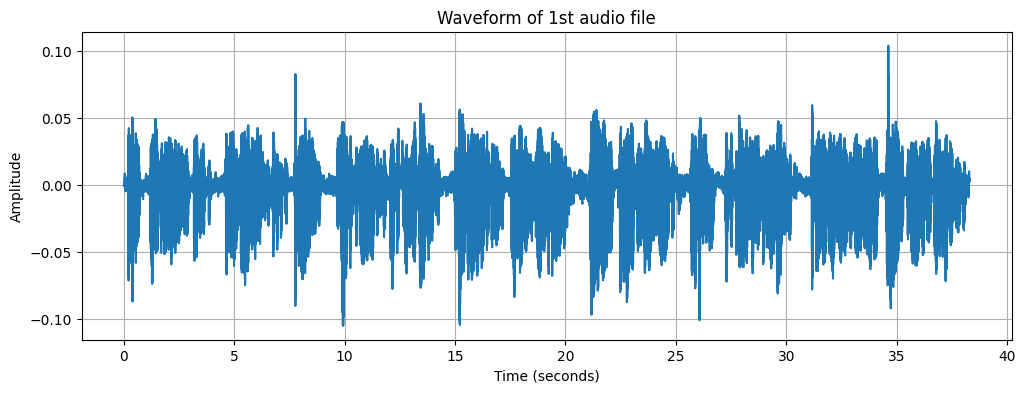

In [8]:
# Extract 1st audio data and sampling rate
waveform = audio_0["array"]
sample_rate = audio_0["sampling_rate"]

# Create time axis in seconds
time_axis = [i / sample_rate for i in range(len(waveform))]

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(time_axis, waveform)
plt.title("Waveform of 1st audio file")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

In [9]:
#Extracting the audios as numpy arrays
files = ds["train"]
audio_arrays = [i['audio']['array'] for i in files]

In [5]:
len(audio_arrays)

1662

I can't easily classify the audio arrays as there are no labels against them. Changing stragety: downloading the dataset into raw_data folder and loading the dataset from there.

In [10]:
#Path to Parkinson's files in raw_data folder
root_dir = "../raw_data/Italian Parkinson's Voice and Speech"

In [11]:
##Create a pd DataFrame with Parkinson's disease classification label (0=healty, 1=Parkinson's)

# Map condition folders to labels
folder_to_label = {
    "15 Young Healthy Control": 0,
    "22 Elderly Healthy Control": 0,
    "28 People with Parkinson's disease": 1
}

data = []

for condition_folder, label in folder_to_label.items():
    condition_path = os.path.join(root_dir, condition_folder)

    if not os.path.exists(condition_path):
        print(f"Skipping missing folder: {condition_path}")
        continue

    # Special case for Parkinson's: one more level deep
    if condition_folder == "28 People with Parkinson's disease":
        # Go through "1-5", "6-10", etc.
        for range_folder in os.listdir(condition_path):
            range_path = os.path.join(condition_path, range_folder)
            if not os.path.isdir(range_path):
                continue
            for subject_folder in os.listdir(range_path):
                subject_path = os.path.join(range_path, subject_folder)
                if not os.path.isdir(subject_path):
                    continue
                wav_files = glob(os.path.join(subject_path, "*.wav"))
                for wav in wav_files:
                    data.append({
                        "filepath": wav,
                        "subject": subject_folder,
                        "group": condition_folder,
                        "label": label
                    })

    else:
        # For healthy controls: subject folders directly inside
        for subject_folder in os.listdir(condition_path):
            subject_path = os.path.join(condition_path, subject_folder)
            if not os.path.isdir(subject_path):
                continue
            wav_files = glob(os.path.join(subject_path, "*.wav"))
            for wav in wav_files:
                data.append({
                    "filepath": wav,
                    "subject": subject_folder,
                    "group": condition_folder,
                    "label": label
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Sanity check
print(f"✅ Found {len(df)} .wav files")
print(df['group'].value_counts())


✅ Found 831 .wav files
group
28 People with Parkinson's disease    437
22 Elderly Healthy Control            349
15 Young Healthy Control               45
Name: count, dtype: int64


In [19]:
df.sample(5)

filepath       subject  \
297  ../raw_data/Italian Parkinson's Voice and Spee...  VITANTONIO D   
217  ../raw_data/Italian Parkinson's Voice and Spee...      TERESA M   
141  ../raw_data/Italian Parkinson's Voice and Spee...      NICOLA P   
770  ../raw_data/Italian Parkinson's Voice and Spee...      Nicolò C   
827  ../raw_data/Italian Parkinson's Voice and Spee...    Giustina M   

                                  group  label  
297          22 Elderly Healthy Control      0  
217          22 Elderly Healthy Control      0  
141          22 Elderly Healthy Control      0  
770  28 People with Parkinson's disease      1  
827  28 People with Parkinson's disease      1

In [40]:
#Select an random file from the subjects with Parkison's
sample = df[df['label'] == 1].sample(1).iloc[0]

# Play the audio directly
print(f"Playing audio from {sample['subject']}: {sample['filepath'].split('/')[-1]}")
ipd.Audio(filename=sample['filepath'])

Playing audio from Giulia P: VU1GPIUUGLL63F100220171027.wav


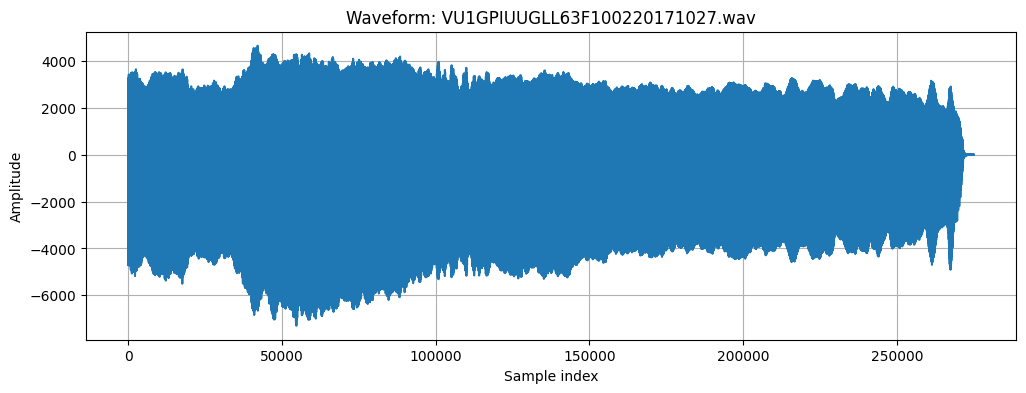

In [42]:
##Plotting the waveform for sample audio

# Read the audio data
sample_rate, audio_data = wavfile.read(sample['filepath'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title(f"Waveform: {sample['filepath'].split('/')[-1]}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)

Text(0.5, 1.0, 'Spectrogram')

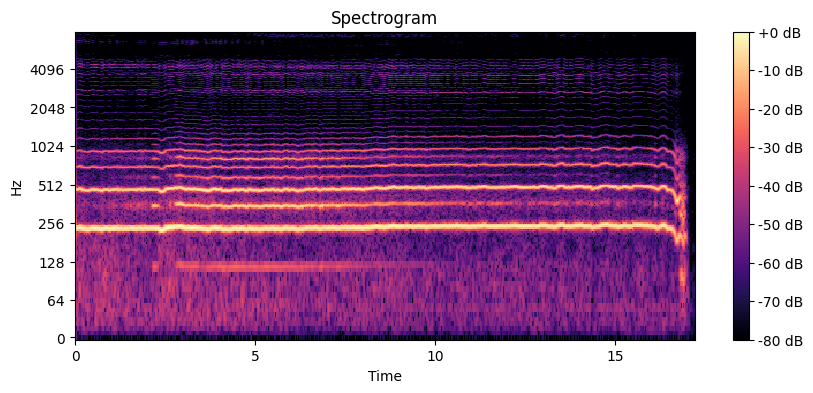

In [44]:
##Spectrogram

# Load audio (returns float32 format)
y, sr = librosa.load(sample['filepath'], sr=None)

# Display spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

In [51]:
#Select an random file from healthy subjects
sample_2 = df[df['label'] == 0].sample(1).iloc[0]

# Play the audio directly
print(f"Playing audio from {sample_2['subject']}: {sample_2['filepath'].split('/')[-1]}")
ipd.Audio(filename=sample_2['filepath'])

Playing audio from LEONARDA F: PR1LFEIOONR57F210320171130.wav


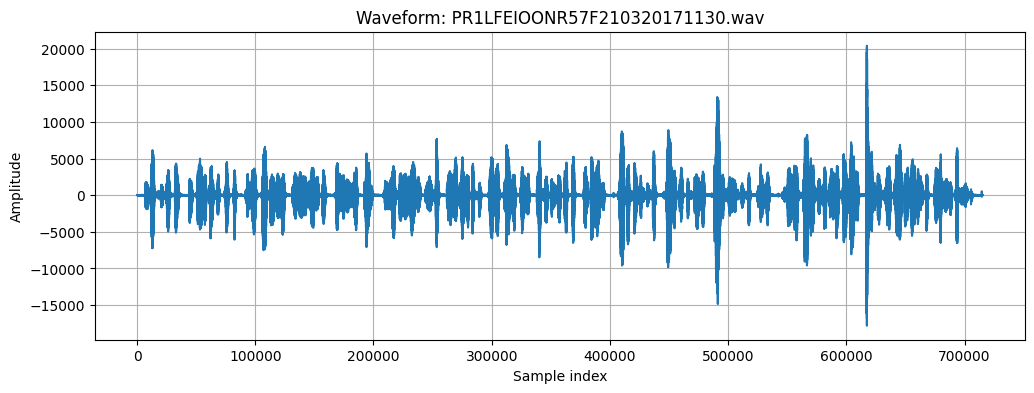

In [52]:
##Plotting the waveform for sample audio

# Read the audio data
sample_rate, audio_data = wavfile.read(sample_2['filepath'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title(f"Waveform: {sample_2['filepath'].split('/')[-1]}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)

Text(0.5, 1.0, 'Spectrogram')

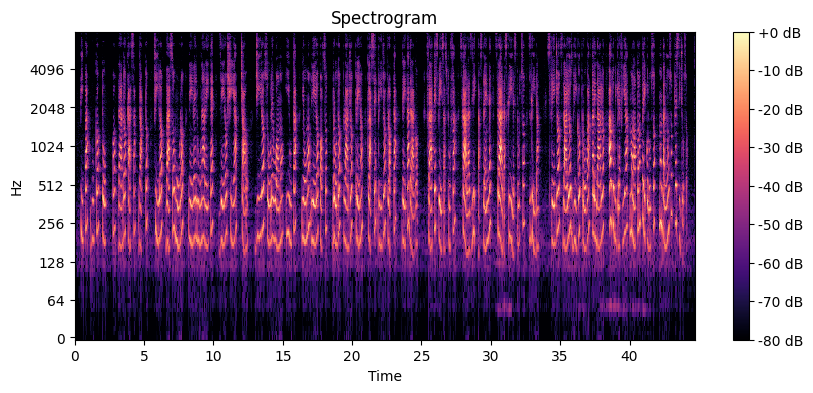

In [53]:
##Spectrogram

# Load audio (returns float32 format)
y, sr = librosa.load(sample_2['filepath'], sr=None)

# Display spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

In [ ]:
def extract_voice_features(file_path):
    snd = parselmouth.Sound(file_path)

    pitch = snd.to_pitch()
    mean_pitch = pitch.selected_array['frequency'][pitch.selected_array['frequency'] > 0].mean()

    point_process = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)

    jitter = parselmouth.praat.call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)

    shimmer = parselmouth.praat.call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    hnr = parselmouth.praat.call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    mean_hnr = parselmouth.praat.call(hnr, "Get mean", 0, 0)

    return {
        "mean_pitch": mean_pitch,
        "jitter": jitter,
        "shimmer": shimmer,
        "hnr": mean_hnr
    }

In [74]:
feature_list = []
for idx, row in df.iterrows():
    try:
        features = extract_voice_features(row['filepath'])
        features['label'] = row['label']  # Add target if available
        features['filename'] = row['filepath'].split('/')[-1]
        features['subject'] = row['subject']
        feature_list.append(features)
    except Exception as e:
        print(f"Error processing {row['filepath']}: {e}")

features_df = pd.DataFrame(feature_list)

In [75]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pitch  831 non-null    float64
 1   jitter      831 non-null    float64
 2   shimmer     831 non-null    float64
 3   hnr         831 non-null    float64
 4   label       831 non-null    int64  
 5   filename    831 non-null    object 
 6   subject     831 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 45.6+ KB


In [81]:
features_df

mean_pitch    jitter   shimmer        hnr  label  \
0    131.527444  0.026996  0.132367  12.019772      0   
1    117.724878  0.034251  0.169478   8.854039      0   
2    217.812372  0.038597  0.197212   6.832119      0   
3    119.841867  0.036121  0.110967   8.403389      0   
4    117.590166  0.032860  0.108852   8.736543      0   
..          ...       ...       ...        ...    ...   
826  155.192650  0.023594  0.074333  16.690465      1   
827  151.715521  0.021709  0.069693  17.829852      1   
828  278.124654  0.014055  0.045229  18.045575      1   
829  219.855682  0.018370  0.103703  14.818904      1   
830  156.151309  0.025482  0.071094  17.345170      1   

                           filename     subject  
0     B1LBULCAAS94M100120171020.wav    Davide M  
1     B2LBULCAAS94M100120171020.wav    Davide M  
2    PR1LBULCAAS94M100120171020.wav    Davide M  
3     B1LBULCAAS94M100120171056.wav    Biagio P  
4     B2LBULCAAS94M100120171056.wav    Biagio P  
..                              ...         ...  
826  FB1GMIAUSST39F100220171206.wav  Giustina M  
827  PR1GMIAUSST39F100220171204.wav  Giustina M  
828  VO1GMIAUSST39F100220171200.wav  Giustina M  
829  VE1GMIAUSST39F100220171159.wav  Giustina M  
830   B1GMIAUSST39F100220171156.wav  Giustina M  

[831 rows x 7 columns]

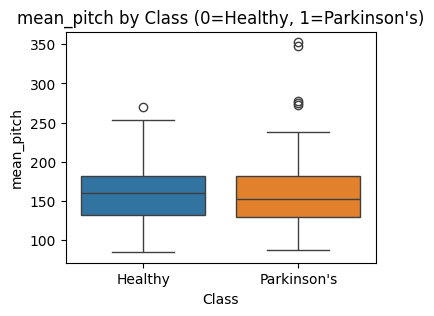

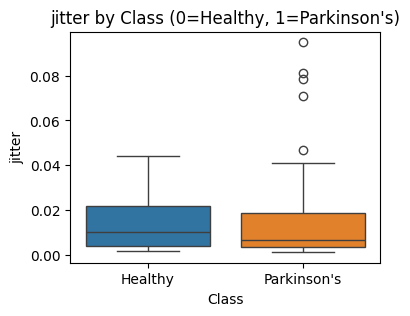

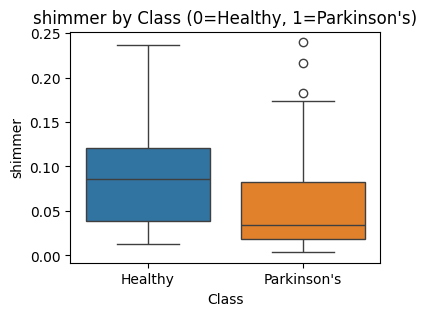

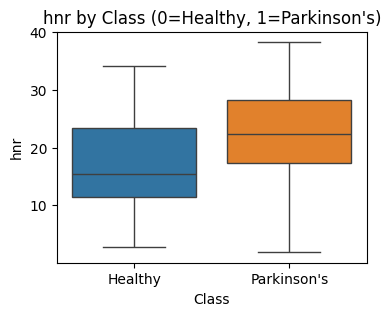

In [ ]:
features_to_plot = ['mean_pitch', 'jitter', 'shimmer', 'hnr']

for feature in features_to_plot:
    plt.figure(figsize=(4, 3))
    sns.boxplot(x='label', y=feature, data=features_df, hue='label', legend=False)
    plt.title(f"{feature} by Class (0=Healthy, 1=Parkinson's)")
    plt.xlabel("Class")
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Healthy', 'Parkinson\'s'])


In [115]:
# Folder containing metadata Excel files
root = Path("../raw_data/Italian Parkinson's Voice and Speech/28 People with Parkinson's disease")

# Recursively find all .xlsx files excluding 'FILE CODES.xlsx'
metadata_files = [
    f for f in root.rglob("*.xlsx") if f.name.lower() != "file codes.xlsx"
]

dfs = []
for file in metadata_files:
    try:
        # Use default header row (first row is column names)
        df = pd.read_excel(file, header=1)
        df.drop(df.columns[0], axis=1, inplace=True)
        df["source_file"] = file.name  # Optional: track where it came from
        dfs.append(df)
    except Exception as e:
        print(f"Could not read {file}: {e}")

# Combine all metadata into one DataFrame
metadata_df = pd.concat(dfs, ignore_index=True)

In [116]:
metadata_df.head()

name surname sex   age time 1      CPS1 time 2       CPS2  time 3  \
0  Felicetta       C   F  63.0     //        //     //         //   60.64   
1   Domenico       C   M  50.0  71.73  7.221525  53.82   9.624675   39.75   
2   Leonarda       L   F  61.0   53.4  9.700375   51.4  10.077821   49.25   
3    Roberto       R   M  68.0  84.05  6.162998  63.32    8.18067   56.66   
4      Lucia       R   F  40.0  60.92  7.764281   52.4   9.885496   54.58   

       CPS3 source_file  
0  4.633905  TAB 5.xlsx  
1  7.069182  TAB 5.xlsx  
2  5.705584  TAB 5.xlsx  
3  4.959407  TAB 5.xlsx  
4  5.148406  TAB 5.xlsx